# Convert a .laz file to .LAS 
#### Needs python = 3.8

In [1]:

import sys
import traceback
import laspy
import os
try:
    print('Running LAZ_to_LAS.py')
    
    def convert_laz_to_las(in_laz, out_las):
        las = laspy.read(in_laz)
        las = laspy.convert(las)
        las.write(out_las)        
    
    in_dir = './'
    
    for (dirpath, dirnames, filenames) in os.walk(in_dir):
        for inFile in filenames:
            if inFile.endswith('.laz'):	
                in_laz = os.path.join(dirpath,inFile)
                
                out_las = in_laz.replace('laz', 'las') 
                print('working on file: ',out_las)
                convert_laz_to_las(in_laz, out_las)
                             
    print('Finished without errors - LAZ_to_LAS.py')
except:
    tb = sys.exc_info()[2]
    tbinfo = traceback.format_tb(tb)[0]
    print('Error in read_xmp.py')
    print ("PYTHON ERRORS:\nTraceback info:\n" + tbinfo + "\nError Info:\n" + str(sys.exc_info()[1]))  

Running LAZ_to_LAS.py
working on file:  ./jogging_bridge_br.las
Finished without errors - LAZ_to_LAS.py


## Visualization with open3D

In [25]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [335]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
        classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
        classified_points.points = input_las.points[input_las.classification == classification]
        
        d["classification_{}".format(str(classification))] = classified_points
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df

def create_laspy_from_dataframe(input_las,combined_df):
    classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]

    return classified_points

def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")
    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [201]:
# Read .las file with the load_laspy() function. Note we cannot handle .laz data.
input_las = load_laspy('Tile65_Original_Clean_Macro.las')
#input_las = load_laspy("200-145324069_ground.las")
#Obtain the classifications available for the dataset
classifications = get_list_classifications(input_las=input_las)
#Create a python dictionary containing the original dataset
# as well as classifications in individual laspy objects.
classifications_laspy =  get_classifications_laspy(input_las=input_las)

#If we choose to export each classification into individual .las files.
#laspy_classifications_to_las(classifications_laspy=classifications_laspy)

#Create a pandas dataframe containing the entire pointcloud.
df = convert_laspy_pandas(input_las=input_las)
#Create a pandas dataframe for ground class "2"
if len(df[df["classification"] == 2]) > 0:
    ground = df[df["classification"] == 2]
#Create a pandas dataframe for low veg class "3"
if len(df[df["classification"] == 3]) > 0:
    low_veg = df[df["classification"] == 3]
#Create a pandas dataframe for med veg class "4"
if len(df[df["classification"] == 4]) > 0:
    med_veg = df[df["classification"] == 4]
#Create a pandas dataframe for high veg class "5"
if len(df[df["classification"] == 5]) > 0:
    high_veg = df[df["classification"] == 5]
#Create a pandas dataframe for high veg class "7"
if len(df[df["classification"] == 7]) > 0:
    low_noise = df[df["classification"] == 7]
#Create a pandas dataframe for high veg class "9"
if len(df[df["classification"] == 9]) > 0:
    topo_water_surface = df[df["classification"] == 9]
#Create a pandas dataframe for high noise "18"
if len(df[df["classification"] == 18]) > 0:
    high_noise = df[df["classification"] == 18]
#Create a pandas dataframe for classified bathymetry "40"
if len(df[df["classification"] == 40]) > 0:
    bathymetry = df[df["classification"] == 40]
#Create a pandas dataframe for classified bathymetric water surface "41"
if len(df[df["classification"] == 41]) > 0:
    bathymetric_water = df[df["classification"] == 41]
#Create a pandas dataframe for classified derived water surface "42"
if len(df[df["classification"] == 42]) > 0:
    derived_water_surface = df[df["classification"] == 42]
#Create a pandas dataframe for bathymetric vegetation "80"
if len(df[df["classification"] == 80]) > 0:
    bathy_veg = df[df["classification"] == 80]
#To get a pandas dataframe with specified classification values
#Inform user which class values are present 
#Proceed by prompting user input to select classes to group into a final dataframe.
class_selections = get_selected_classes(classifications = classifications,input_las=input_las)
# Form a pandas dataframe from user-selected classifications
combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)

##Create laspy points from the pandas dataframe of selected user classifications
classified_points = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

###                                 ###
###DATA CONVERSION FOR VISUALIZATION###
###             #                   ###
# Convert classified_points (laspy data) or combined_df (pandas data) to numpy data for visualization
#   with the pptk library. 
#Convert from laspy to numpy scaled
classified_points_numpy_scaled_laspy = get_numpy_points_from_laspy_scaled(classified_points=classified_points)
#Convert from laspy to numpy unscaled
classified_points_numpy_unscaled_laspy = get_numpy_points_from_laspy_unscaled(classified_points=classified_points)
#Convert from pandas to numpy scaled
classified_points_numpy_scaled_pandas = get_numpy_points_from_pandas_scaled(combined_df=combined_df)
#Convert from pandas to numpy unscaled
classified_points_numpy_unscaled_pandas = get_numpy_points_from_pandas_unscaled(combined_df=combined_df)



########Individual Classifications#######
low_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = low_noise)
topo_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = topo_water_surface)
high_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = high_noise)
bathymetry_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetry)
bathymetric_water_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetric_water)
derived_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = derived_water_surface)
bathy_veg_unscaled = get_numpy_points_from_pandas_unscaled(combined_df =bathy_veg)

The classifications contained in this .las dataset are: 
[0, 7, 9, 18, 40, 41, 42, 80]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 0
Saving classification number: 7
Saving classification number: 9
Saving classification number: 18
Saving classification number: 40
Saving classification number: 41
Saving classification number: 42
Saving classification number: 80
Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
The entire dataset has been selected
All classes have been added to the dataframe.


In [234]:
#visualize_las(classified_points=classified_points_numpy_scaled_laspy)
visualize_las(classified_points=classified_points_numpy_unscaled_laspy,df=combined_df)

entered df


In [229]:
multiple_classifications_to_las(classified_points=classified_points,class_selections=class_selections)

AttributeError: 'numpy.ndarray' object has no attribute 'write'

In [28]:
import pandas as pd

classes_esri = pd.read_html("https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/lidar-point-classification.htm")
classes_esri[1]

,Classification value,Meaning
0,0,Never classified
1,1,Unassigned
2,2,Ground
3,3,Low Vegetation
4,4,Medium Vegetation
5,5,High Vegetation
6,6,Building
7,7,Low Point
8,8,Reserved*
9,9,Water


## Dig into the data

Bathymetry vegetation

In [45]:
#bathy_veg_unscaled
bathy_veg

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2601,290992999,-186802064,-5923,290992.999,4813197.936,-5.923,16914,80,1,6,0,0,0,0,0,1,2,-1760,2610,135243.746899
2607,290991766,-186801812,-5849,290991.766,4813198.188,-5.849,22487,80,2,3,0,0,0,0,0,1,2,-1732,2610,135243.746928
2629,290996698,-186803948,-6024,290996.698,4813196.052,-6.024,22124,80,1,2,0,0,0,0,0,1,2,-1856,2610,135243.765407
2649,290989339,-186802534,-5822,290989.339,4813197.466,-5.822,15202,80,2,5,0,0,0,0,0,1,2,-1691,2610,135243.765580
2739,290997434,-186806481,-6080,290997.434,4813193.519,-6.080,23758,80,1,3,0,0,0,0,0,1,2,-1899,2610,135243.802579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475630,291019886,-186958735,-5806,291019.886,4813041.265,-5.806,4457,80,5,6,0,0,0,0,0,0,4,2643,2812,135839.330419
1475638,291024783,-186958751,-5775,291024.783,4813041.249,-5.775,743,80,4,5,0,0,0,0,0,0,4,2556,2812,135839.330521
1475645,291028322,-186958909,-5577,291028.322,4813041.091,-5.577,1920,80,3,4,0,0,0,0,0,0,4,2492,2812,135839.330593
1475648,291029709,-186958932,-5777,291029.709,4813041.068,-5.777,8561,80,3,4,0,0,0,0,0,0,4,2466,2812,135839.330622


In [20]:
bathy_veg.X.max(),bathy_veg.X.min(),bathy_veg.X.max()-bathy_veg.X.min()

(291074353, 290917905, 156448)

In [21]:
bathy_veg.Y.max(),bathy_veg.Y.min(),bathy_veg.Y.max()-bathy_veg.Y.min()

(-186800961, -186959090, 158129)

In [22]:
bathy_veg.Z.max(),bathy_veg.Z.min(),bathy_veg.Z.max()-bathy_veg.Z.min()

(-1596, -9021, 7425)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [304]:
from sklearn.preprocessing import StandardScaler

combined_df_XYZ = combined_df[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(combined_df_XYZ)
combined_df_XYZ_scaled = scaler.transform(combined_df_XYZ)

scaler = StandardScaler()
scaler.fit(combined_df)
combined_df_scaled = scaler.transform(combined_df)
scaled_features_df = pd.DataFrame(combined_df_scaled, index=combined_df.index, columns=combined_df.columns)
#scaled_features_df

visualize_las(classified_points=combined_df_XYZ_scaled,df=scaled_features_df[["X","Y","Z"]])

entered df


In [305]:
from sklearn.preprocessing import StandardScaler

bathy_veg_df_XYZ = bathy_veg[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(bathy_veg_df_XYZ)
bathy_veg_pd_XYZ_scaled = scaler.transform(bathy_veg_df_XYZ)

scaler = StandardScaler()
scaler.fit(bathy_veg)
bathy_veg_scaled = scaler.transform(bathy_veg)
bathy_veg_scaled_df = pd.DataFrame(bathy_veg_scaled, index=bathy_veg.index, columns=bathy_veg.columns)
#scaled_features_df

visualize_las(classified_points=bathy_veg_pd_XYZ_scaled,df=bathy_veg_scaled_df[["X","Y","Z"]])

entered df


In [314]:
#derived_water_surface
from sklearn.preprocessing import StandardScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = StandardScaler()
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [322]:
from sklearn.preprocessing import MinMaxScaler
combined_df_XYZ = combined_df[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(combined_df_XYZ)
combined_df_XYZ_scaled = scaler.transform(combined_df_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(combined_df)
combined_df_scaled = scaler.transform(combined_df)
scaled_features_df = pd.DataFrame(combined_df_scaled, index=combined_df.index, columns=combined_df.columns)
#scaled_features_df

visualize_las(classified_points=combined_df_XYZ_scaled,df=scaled_features_df[["X","Y","Z"]])

entered df


In [325]:
from sklearn.preprocessing import MinMaxScaler

bathy_veg_df_XYZ = bathy_veg[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(bathy_veg_df_XYZ)
bathy_veg_pd_XYZ_scaled = scaler.transform(bathy_veg_df_XYZ)

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(bathy_veg)
bathy_veg_scaled = scaler.transform(bathy_veg)
bathy_veg_scaled_df = pd.DataFrame(bathy_veg_scaled, index=bathy_veg.index, columns=bathy_veg.columns)
#scaled_features_df

visualize_las(classified_points=bathy_veg_pd_XYZ_scaled,df=bathy_veg_scaled_df[["X","Y","Z"]])

entered df


In [324]:
#derived_water_surface
from sklearn.preprocessing import MinMaxScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df


In [326]:
pip install pyvista

     ---------------------------------------- 1.6/1.6 MB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 56.3/56.3 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 49.2/49.2 MB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 2.0 MB/s eta 0:00:00
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.14-py2.py3-none-any.whl (140 kB)
     ---------------------------------------- 95.8/95.8 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [330]:
derived_water_surface

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2583,290998856,-186802008,-284,290998.856,4813197.992,-0.284,65530,42,0,2,0,0,0,0,0,1,2,-1897,2610,135243.746754
2586,290997639,-186801812,-280,290997.639,4813198.188,-0.280,65530,42,0,1,0,0,0,0,0,1,2,-1869,2610,135243.746783
2588,290996426,-186801609,-273,290996.426,4813198.391,-0.273,65530,42,0,5,0,0,0,0,0,1,2,-1842,2610,135243.746812
2594,290995196,-186801391,-257,290995.196,4813198.609,-0.257,65530,42,0,3,0,0,0,0,0,1,2,-1815,2610,135243.746841
2598,290993964,-186801165,-244,290993.964,4813198.835,-0.244,65530,42,0,1,0,0,0,0,0,1,2,-1787,2610,135243.746871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475458,291022825,-186959005,-251,291022.825,4813040.995,-0.251,65530,42,0,2,0,0,0,0,0,0,4,2610,2812,135839.302463
1475461,291024199,-186959004,-242,291024.199,4813040.996,-0.242,65530,42,0,3,0,0,0,0,0,0,4,2585,2812,135839.302492
1475465,291025607,-186959020,-226,291025.607,4813040.980,-0.226,65530,42,0,3,0,0,0,0,0,0,4,2560,2812,135839.302521
1475469,291027003,-186959050,-212,291027.003,4813040.950,-0.212,65530,42,0,2,0,0,0,0,0,0,4,2534,2812,135839.302550


In [327]:
from sklearn.decomposition import PCA

derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z","intensity"]]

pca = PCA(n_components=3)
 
PC = pca.fit_transform(derived_water_surface_XYZ_scaled)

pca_cloud = pd.DataFrame(data = PC,
              columns = ['PC1', 'PC2','PC3'])
 
pca_cloud.head(6)

,PC1,PC2,PC3
0,-0.790647,0.582859,0.229098
1,-0.784559,0.595239,0.246118
2,-0.779029,0.606321,0.274480
3,-0.774905,0.613773,0.336907
4,-0.770393,0.622607,0.387995
5,-0.763871,0.637479,0.382293


In [329]:
pca_cloud

,PC1,PC2,PC3
0,-0.790647,0.582859,0.229098
1,-0.784559,0.595239,0.246118
2,-0.779029,0.606321,0.274480
3,-0.774905,0.613773,0.336907
4,-0.770393,0.622607,0.387995
...,...,...,...
425927,0.671340,-0.799616,0.255584
425928,0.660086,-0.817891,0.287568
425929,0.647700,-0.839687,0.345965
425930,0.635850,-0.860588,0.396811


In [338]:
visualize_las(np.array(pca_cloud),df=derived_water_surface[["X","Y","Z"]])

entered df


In [337]:
#derived_water_surface
from sklearn.preprocessing import MinMaxScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df


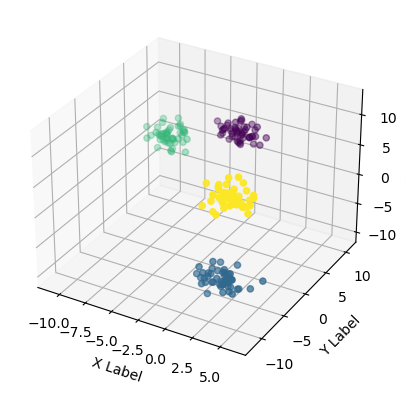

In [34]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3-dimensional clusters
X, y  = make_blobs(n_samples=200,centers= 4,cluster_std=1,n_features=3,random_state=42)

# Plot the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [72]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
o3d.io.write_point_cloud("./random_data.ply", pcd)


ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud("random_data.ply")


True

In [5]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
X, labels  = make_blobs(n_samples=20000,centers= 2,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1, min_points=10, print_progress=True))

# Visualize the clusters using Open3D
colors = np.random.rand(np.max(labels) + 1, 3)
colors[0] = [0, 0, 0]  # set the color for unassigned points
pcd.colors = o3d.utility.Vector3dVector(colors[labels])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2                       ] 2%
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [108]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
X, labels  = make_blobs(n_samples=2000,centers= 4,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



[Open3D DEBUG] Precompute neighbors.
Precompute neighbors.[========[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 6
point cloud has 6 clusters
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


Try this on lidar data

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
#X, labels  = make_blobs(n_samples=2000,centers= 4,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(classified_points_numpy_scaled_laspy)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=100, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



: 

: 